#### Importing the Cornell Movie Review set

In [2]:
import pandas as pd
import os
import fnmatch

CORNELL_DATA = 'data/cornell'
IMDB_DATASET = 'imdb.npz'
RATERS       = ['Dennis+Schwartz', 'James+Berardinelli', 'Scott+Renshaw', 'Steve+Rhodes']

def feature_label_pair(path, feature_reg, label_reg):
    """Finds and returns a relative path for a feature and label file.
    
    This function is intended to locate feature label pairs in a directory.
    
    Args:
        path (str)      : the path to the searched directory
        feature_reg(str): a regex for the feature file
        label_reg (str) : a regex for the label file
        
    Returns:
        A tuple of feature file's path and label's file path or None if one (or both)
        aren't located.
        
    """
    feature_file = ''
    label_file = ''
    for file in os.listdir(path):
        if fnmatch.fnmatch(file, feature_reg):
            feature_file = os.path.join(path, file)
        if fnmatch.fnmatch(file, label_reg):
            label_file = os.path.join(path, file)
        if feature_file and label_file:
            return (feature_file, label_file)
    return

cornell_df   = pd.DataFrame()
for r in RATERS:
    (ff, lf)          = feature_label_pair(os.path.join(CORNELL_DATA, r), 'subj*', 'rating*')
                        # pandas doesn't have ignore separator feature
    feat_df           = pd.read_csv(ff, names='x', sep='☺️')
    label_df          = pd.read_csv(lf, names='y')
    rater_df          = pd.concat([feat_df, label_df], axis=1)
    rater_df['rater'] = r
    cornell_df        = pd.concat([cornell_df, rater_df], axis=0, ignore_index=True)

print(cornell_df.head())

/media/zachary/Data/Codebase/cs4390/venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


                                                   x    y            rater
0  in my opinion , a movie reviewer's most import...  0.1  Dennis+Schwartz
1  you can watch this movie , that is based on a ...  0.2  Dennis+Schwartz
2  this is asking a lot to believe , and though i...  0.2  Dennis+Schwartz
3  no heroes and no story are the main attributes...  0.2  Dennis+Schwartz
4  this is not an art movie , yet i saw it an art...  0.2  Dennis+Schwartz


#### Tokenize

In [5]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
cornell_df['x_tok'] = [tokenizer.tokenize(r) for r in cornell_df['x']]

#### Lemmatization

In [36]:
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
import numpy as np

def lemmatize_row(row):
    
    lem = []
    lemmatizer = WordNetLemmatizer()
    
    for w in row:
        lem.append(lemmatizer.lemmatize(w))
        
    return lem
        

[nltk_data] Downloading package wordnet to /home/zachary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
cornell_df['x_lem'] = [ lemmatize_row(r) for r in cornell_df['x_tok'] ]

#### Padding Data

Max:  2606
Min:  10


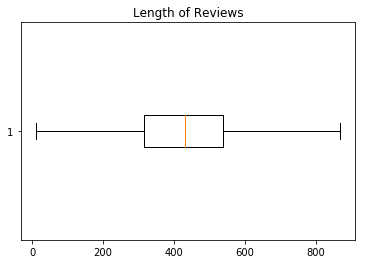

In [53]:
%matplotlib inline

import matplotlib.pyplot as plt
 

sample_lengths = list(map(len, cornell_df['x_lem']))

fig1, ax1 = plt.subplots()
ax1.set_title('Length of Reviews')
ax1.boxplot(sample_lengths, showfliers=False, vert=False)

print('Max: ', max(sample_lengths))
print('Min: ', min(sample_lengths))

In [105]:
# ~Q3
THR = 550

# Reduces all rows to length THR with rows less than THR padded with empty strings
cornell_df['x_lem_thr'] = [ np.pad(r[:THR], (0, THR - len(r[:THR])), 'constant', constant_values='') \
                           for r in cornell_df['x_lem'] ]

#### TF-IDF

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer

# prune words that are too frequent(stop words) and super rare words
tfidf = TfidfVectorizer(max_df=0.9, min_df=0.05)

# the way sklearn want the data
tmp   = [ ' '.join(r) for r in cornell_df['x_lem_thr'] ]

tfidf_data = tfidf.fit_transform(tmp)

#### Random Forest (Baseline)

In [158]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

forest = RandomForestRegressor(random_state=99, n_estimators=100)

X_train, X_test, y_train, y_test = train_test_split(tfidf_data, cornell_df['y'], 
                                                    test_size=0.25, 
                                                    random_state=99,
                                                    shuffle=True)

params = { 'max_depth': [2, 3, 4, 5, 6, 7] }

model = GridSearchCV(estimator=forest, param_grid=params, cv=5, return_train_score=True, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=99, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [152]:
model.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=99, verbose=0, warm_start=False)

In [154]:
print("Forest Score: ", model.score(X_test, y_test))

1.6636400441203911